In [5]:
!pip install scanpy anndata

# Core scverse libraries
import scanpy as sc
import anndata as ad
import os
import matplotlib.pyplot as plt


In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
data_dir = '/content/drive/MyDrive/mm_blood_10x'

sample = 'blood_12w_WT_02'

mtx_dir = os.path.join(data_dir, sample, 'mtx')  # The 'mtx' folder contains the matrix, barcodes, and features

adata = sc.read_10x_mtx(mtx_dir, var_names='gene_symbols', cache=True)

adata.obs_names = adata.obs_names.str.strip()  # Clean any extra spaces in barcode names
adata.var_names = adata.var_names.str.strip()  # Clean any extra spaces in gene names

adata.obs_names_make_unique()

print(adata)

#AnnData object with n_obs × n_vars = 13412 × 32285
    #var: 'gene_ids', 'feature_types'


AnnData object with n_obs × n_vars = 13412 × 32285
    var: 'gene_ids', 'feature_types'


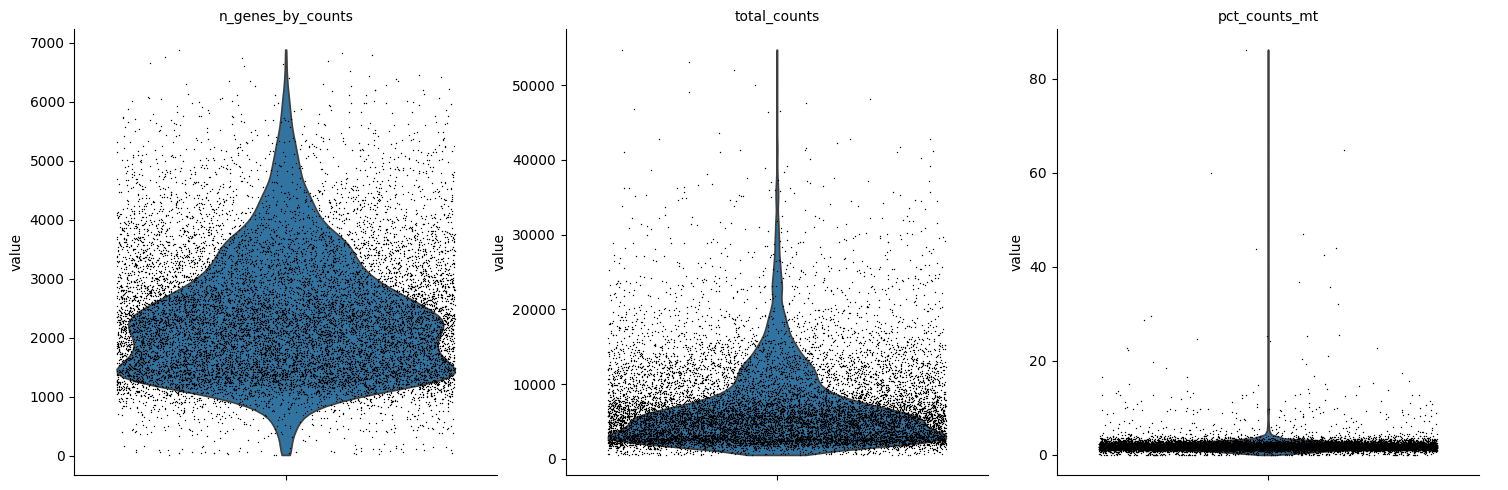

In [8]:

adata.var["mt"] = adata.var_names.str.lower().str.startswith("mt-")

adata.var["ribo"] = adata.var_names.str.lower().str.startswith("rps","rpl")

adata.var["hb"] = adata.var_names.str.lower().str.startswith("hb")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)


sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

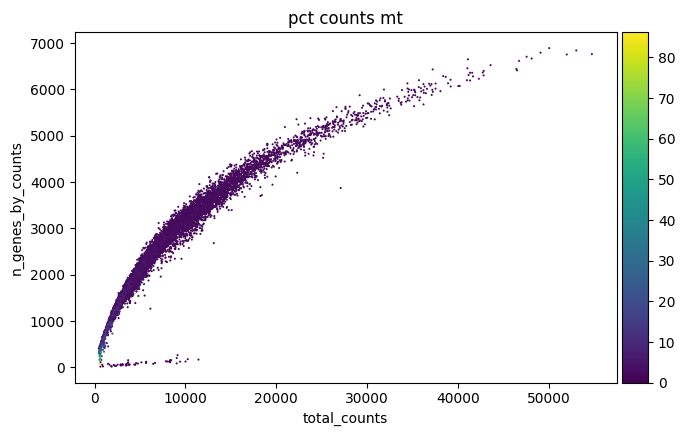

In [9]:
#scatter plot colored by pct_counts_mt
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

1. **n_genes_by_counts**: number of genes expressed in each individual cell

*   low: cell of low quality or dead
*   high: healty, active cell
  
2. **total_counts**: total number of RNA reads, total amount of expression across all genes in a cell

*  low: poor quality cell
*  high: active cells


3. **pct_count_mt**: percentage of RNA reads from mt genes. mi genes are elevated in cells that are streed or dying
  
*  high: poor quality cell




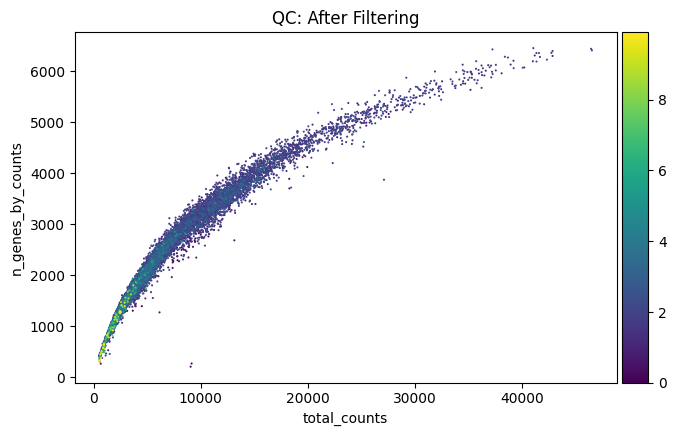

Number of cells left: 13274
Number of genes left: 17144


In [10]:
#Filtering

#Filter based on total genes by count
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=5)


# Further filter out cells with >10% mitochondrial gene content, and total counts more than 6500
adata = adata[adata.obs['pct_counts_mt'] < 10, :]
adata = adata[adata.obs.n_genes_by_counts < 6500, :]

sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", color="pct_counts_mt", title="QC: After Filtering")


# Print the number of cells and genes after filtering
print(f"Number of cells left: {adata.n_obs}")
print(f"Number of genes left: {adata.n_vars}")

#13274 x 17144 after filtering


In [11]:
#Doublet detection
#After the filtering step to reduce runtime


adata.obs["sample"] = "blood_12w_WT_02"

sc.pp.scrublet(adata, batch_key="sample")


print(adata.obs[["doublet_score", "predicted_doublet"]])

print(adata.obs[adata.obs['predicted_doublet'] == True])

#no predicted doublet in this dataset


<ipython-input-11-6d1cca8f71cd>:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["sample"] = "blood_12w_WT_02"


                    doublet_score  predicted_doublet
AAACCCAAGCGTCTGC-1       0.089968              False
AAACCCACAATTGCTG-1       0.015544              False
AAACCCACAGCACAAG-1       0.095853              False
AAACCCATCACTCCGT-1       0.117694              False
AAACCCATCATTACGG-1       0.059048              False
...                           ...                ...
TTTGTTGTCCCAAGCG-1       0.047267              False
TTTGTTGTCGAAATCC-1       0.017483              False
TTTGTTGTCGGCTATA-1       0.008436              False
TTTGTTGTCTTCCAGC-1       0.034226              False
TTTGTTGTCTTGTGCC-1       0.069223              False

[13274 rows x 2 columns]
Empty DataFrame
Columns: [n_genes_by_counts, log1p_n_genes_by_counts, total_counts, log1p_total_counts, pct_counts_in_top_50_genes, pct_counts_in_top_100_genes, pct_counts_in_top_200_genes, pct_counts_in_top_500_genes, total_counts_mt, log1p_total_counts_mt, pct_counts_mt, total_counts_ribo, log1p_total_counts_ribo, pct_counts_ribo, tot

In [12]:
#Normalization
#to make data comparable across cells, since raw data can vary between cells due to technical/biological factors

adata.layers["counts"] = adata.X.copy() #copies raw count matrix into a new layer "counts", so raw data is preserved

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)



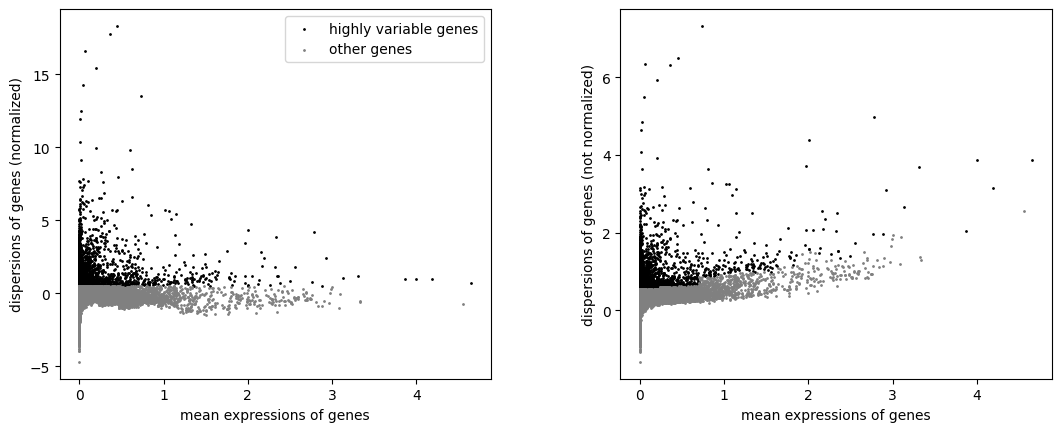

In [13]:
#Feature Selection
#reduces dimensionality by keeping the highly variable genes (HVGs), which are more informative as they show
#variability across cells, reflecting differences in cell states/types/biolgocial processes.

#keeping top 3000 most variable genes here
sc.pp.highly_variable_genes(adata, n_top_genes=3000)  # Keep the top 3000 most variable genes

sc.pl.highly_variable_genes(adata)


**x-axis**: mean expression of each gene. genes on left have low mean expression.

**y-axis**: how variable a gene's expression is across all cells. upper region (higher variability) are more informative for downstream analysis



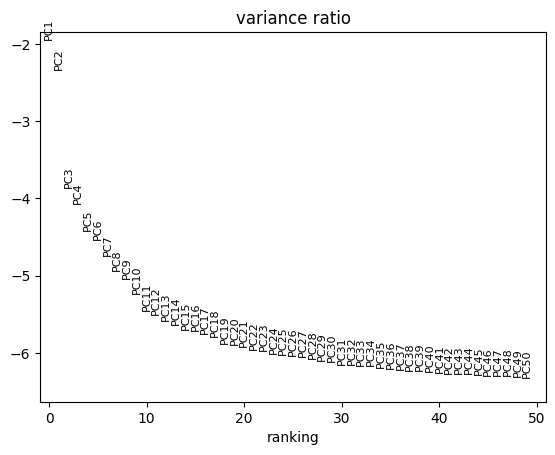

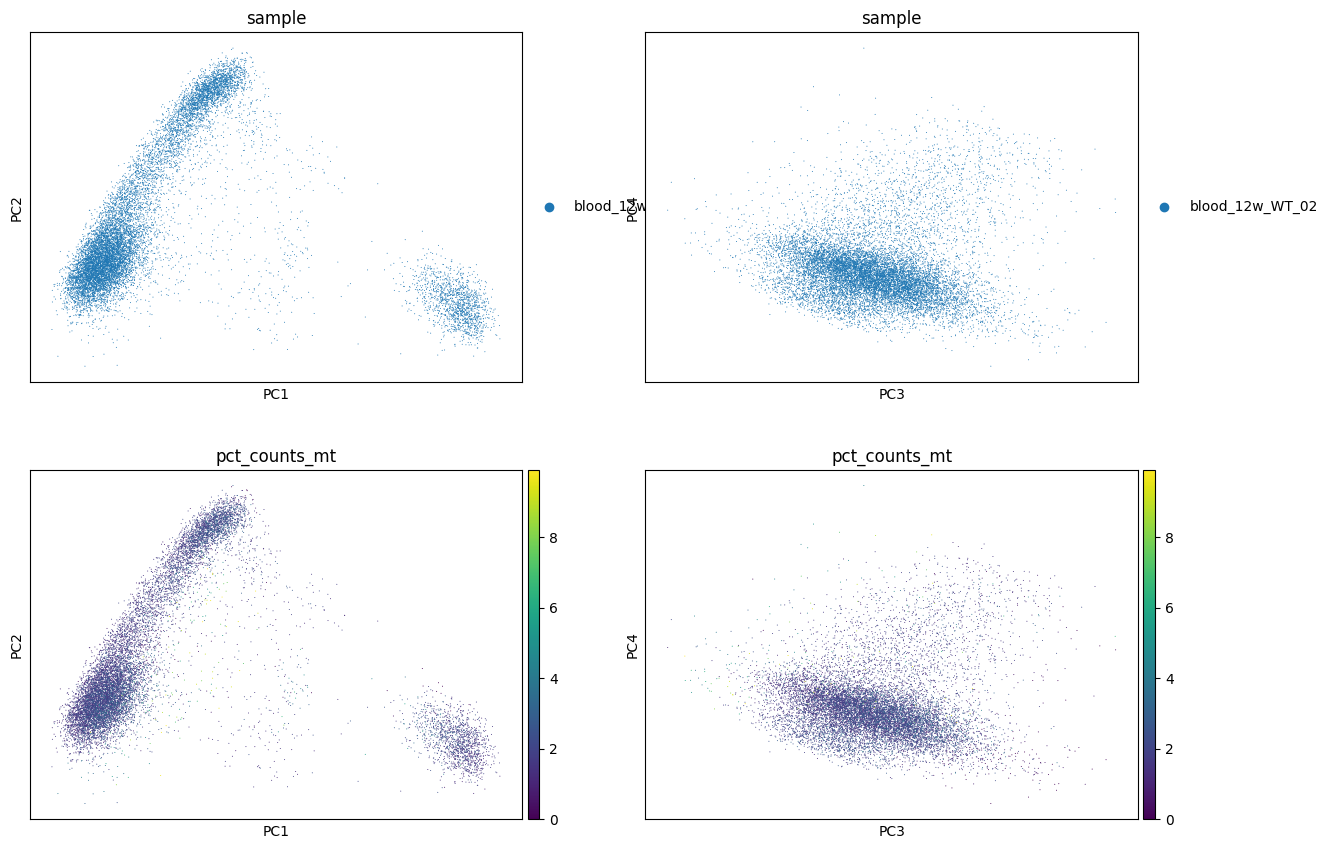

In [14]:
#Dimension Reduction

sc.tl.pca(adata)

sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)
#the elbow is at pc3

sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)
